In [1]:
# %matplotlib widget

import os
import numpy as np
import pandas as pd
from copy import deepcopy as copy
from astropy.table import Table

from lvmdrp import path, __version__ as drpver
from lvmdrp.core.constants import ARC_LAMPS, SPEC_CHANNELS
from lvmdrp.core import rss
from lvmdrp.utils import metadata as md
from lvmdrp.functions import run_drp as drp

from lvmdrp.functions import imageMethod, rssMethod


import matplotlib.pyplot as plt
from lvmdrp.core.spectrum1d import Spectrum1D


def subtract_continuum(in_rss, out_rss, median_box=30, thresh=1.2, niter=5, mask_delt=1):
    arc = rssMethod.loadRSS(in_rss)
    
    cont_rss = np.zeros_like(arc._data)
    for ifiber in range(arc._fibers):
        if ifiber not in arc._good_fibers:
            continue
        spec = arc.getSpec(ifiber)

        spec_s = copy(spec)
        spec_s.smoothSpec(size=median_box, method="median")

        cur_mask = 0
        for i in range(niter):
            mask = np.divide(spec._data, spec_s._data, where=spec_s._data != 0, out=np.zeros_like(spec_s._data)) < thresh

            spec_s = Spectrum1D(data=np.interp(spec._pixels, spec._pixels[mask], spec._data[mask]))
            spec_s.smoothSpec(size=30, method="median")

            if np.abs(cur_mask - mask.sum()) <= mask_delt: break
            cur_mask = mask.sum()

        # define continuum with last iteration's mask
        mask = np.divide(spec._data, spec_s._data, where=spec_s._data != 0, out=np.zeros_like(spec_s._data)) < thresh
        cont_rss[ifiber] = np.interp(spec._pixels, spec._pixels[mask], spec._data[mask])
    
    out_con = copy(arc)
    out_con.setData(data=cont_rss)
    new_arc = copy(arc)
    new_arc.setData(data=arc._data - cont_rss)
    
    new_arc.writeFitsData(out_rss)
    
    return new_arc, out_con


ORIG_MASTER_DIR = os.getenv("LVM_MASTER_DIR")
MASTER_CON_LAMPS = {"b": "ldls", "r": "ldls", "z": "quartz"}
MASTER_ARC_LAMPS = {"b": "hgne", "r": "neon", "z": "neon"}
SLITMAP = Table(drp.fibermap.data)

In [2]:
frames_table = md.get_metadata(tileid="*", mjd=60177)
frames_table.query("imagetyp == 'bias' | imagetyp == 'dark' | imagetyp == 'flat' | imagetyp == 'arc'", inplace=True)
frames_table = frames_table.loc[frames_table.name.str.contains("sdR")]

[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/data.sdss5.org/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/raw_metadata.hdf5
[INFO]: found 522 frames in store '/home/mejia/Research/lvm/lvmdata/data.sdss5.org/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/raw_metadata.hdf5'
[INFO]: number of frames after filtering 522
[INFO]: total number of frames found 522


In [3]:
masters_mjd = frames_table.mjd.min()
masters_path = os.path.join(ORIG_MASTER_DIR, f"{masters_mjd}")
os.makedirs(masters_path, exist_ok=True)

[INFO]: reading arc from '/home/mejia/Research/lvm/lvmdata/data.sdss5.org/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/calib/lvm-wmarc_neon_hgne_argon_xenon-b1.fits'
[INFO]: pixel-to-wavelength map in file '/home/mejia/Research/lvm/lvmdrp/python/lvmdrp/etc/wavelength/lvm-pixwav-neon_hgne_argon_xenon_b1.txt'
[INFO]: going to use fiber 319 as reference
[INFO]: number of lines in file 34 percentage masked  67.6471 %
[INFO]: going to use 11 lines
[INFO]: measuring arc lines for each fiber from reference fiber 319, flux_min = 1e-12, fwhm_max = 5 and relative flux limits [0.001, 1000000000000.0]


combined lamps:  /home/mejia/Research/lvm/lvmdata/data.sdss5.org/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/calib/lvm-wmarc_neon_hgne_argon_xenon-b1.fits


measuring arc lines upwards from ref_fiber = 319: 100%|################################################| 319/319 [00:01<00:00, 166.17fiber/s]
measuring arc lines downwards from ref_fiber = 319: 100%|##############################################| 328/328 [00:01<00:00, 172.90fiber/s]


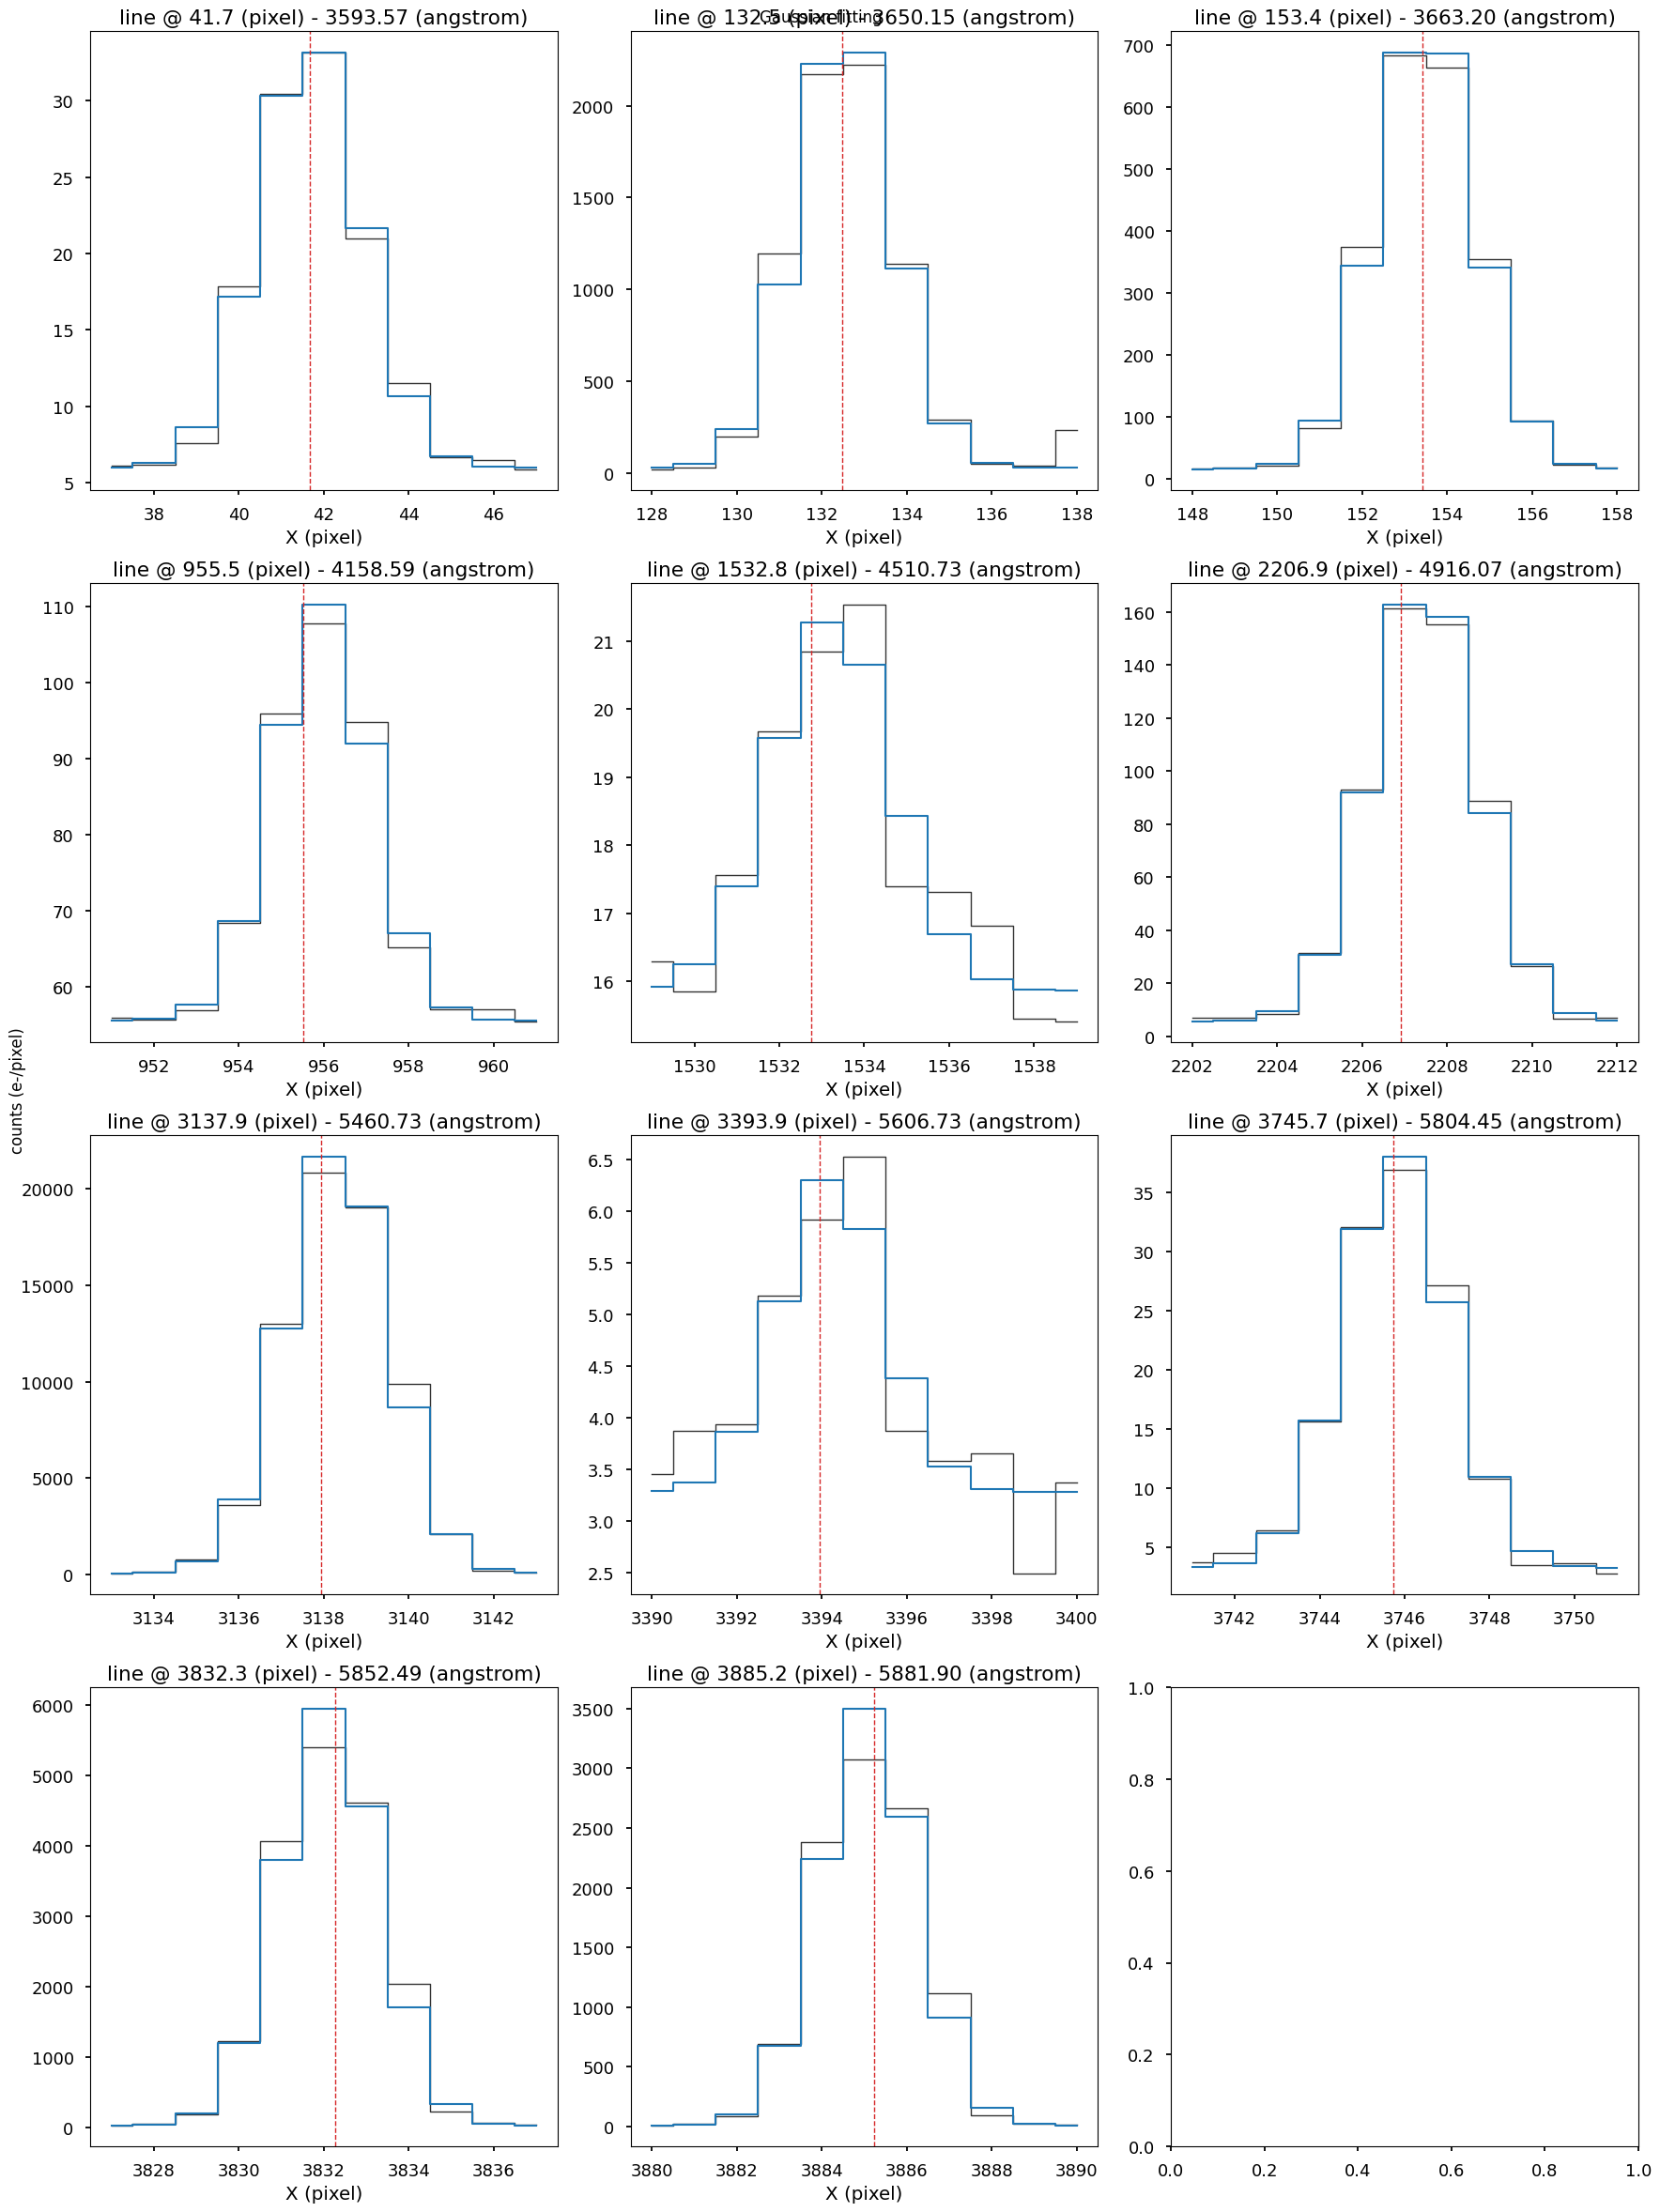

[INFO]: smoothing FWHM of guess lines along cross-dispersion axis using 2-deg polynomials
[INFO]: fitting wavelength solutions using 5-deg polynomials
[WARNING]: fiber 1 has all lines masked
[WARNING]: fiber 109 has all lines masked
[WARNING]: fiber 217 has all lines masked
[WARNING]: fiber 289 has all lines masked
[WARNING]: fiber 325 has all lines masked
[WARNING]: fiber 397 has all lines masked
[WARNING]: fiber 414 has all lines masked
[WARNING]: fiber 462 has all lines masked
[WARNING]: fiber 505 has all lines masked
[WARNING]: fiber 613 has all lines masked
[INFO]: finished wavelength fitting with median RMS = 0.0273481 AA (0.0464175 pix)
[INFO]: fitting LSF solutions using 2-deg polynomials
[INFO]: finished LSF fitting with median RMS = 0.0679798 AA (0.11415 pix)


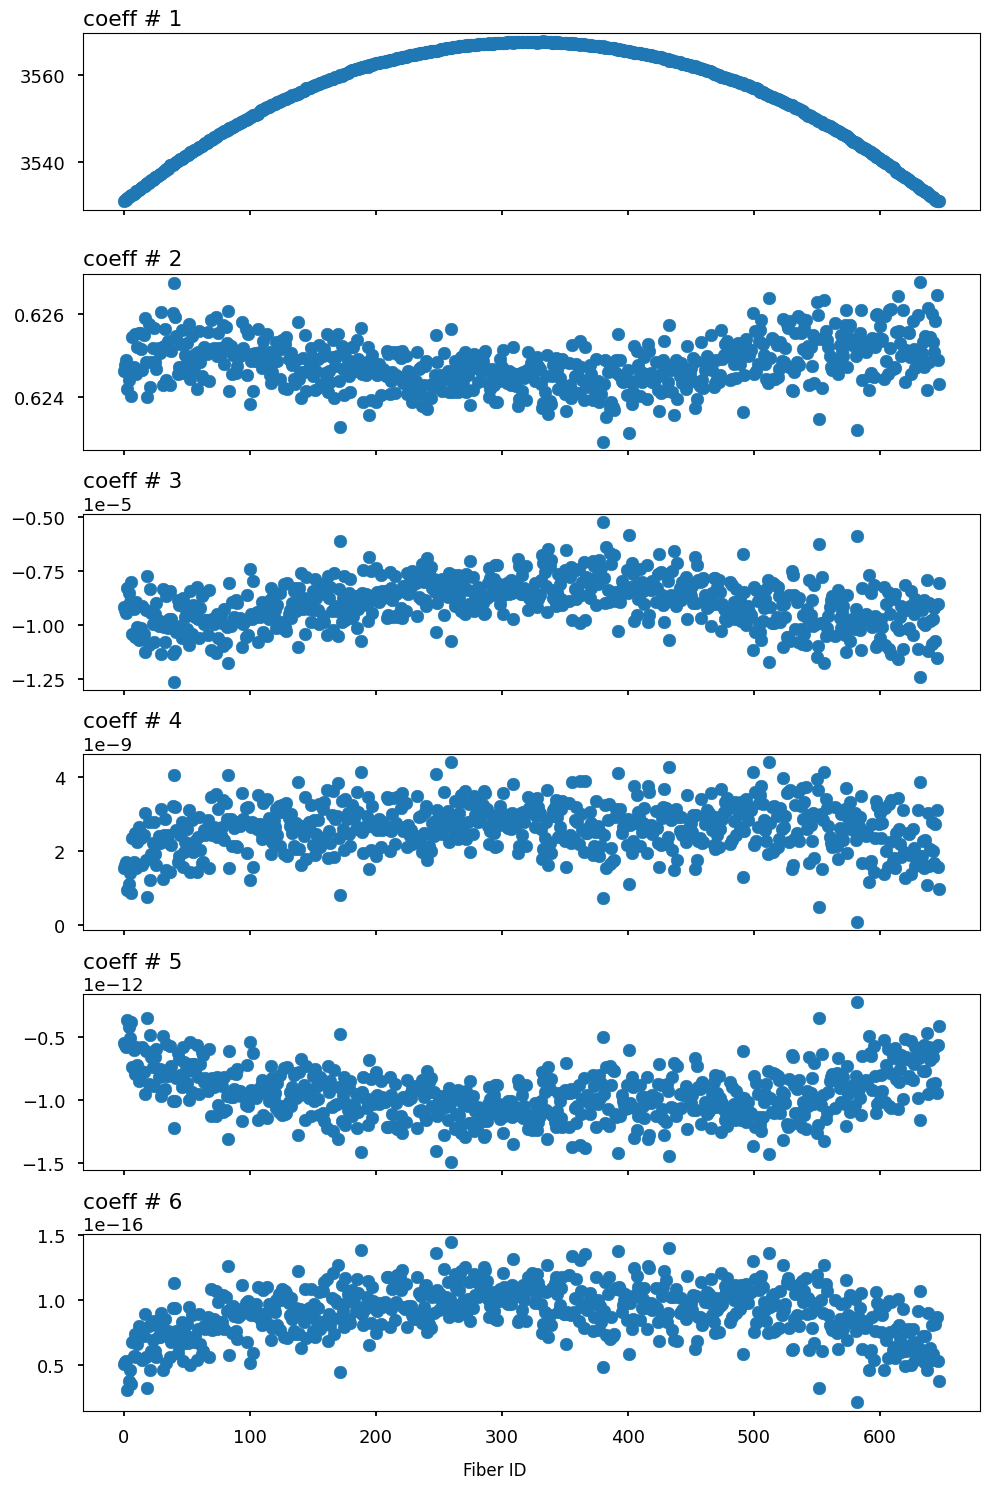

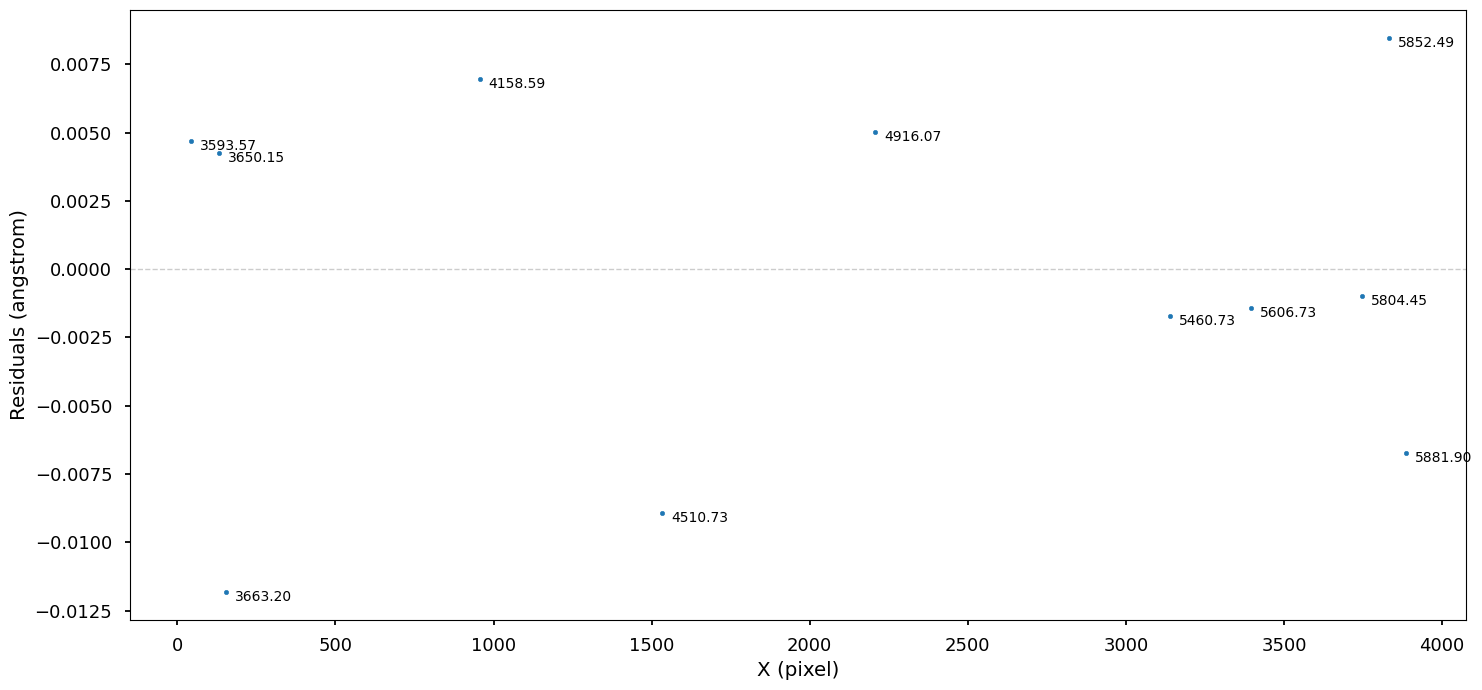

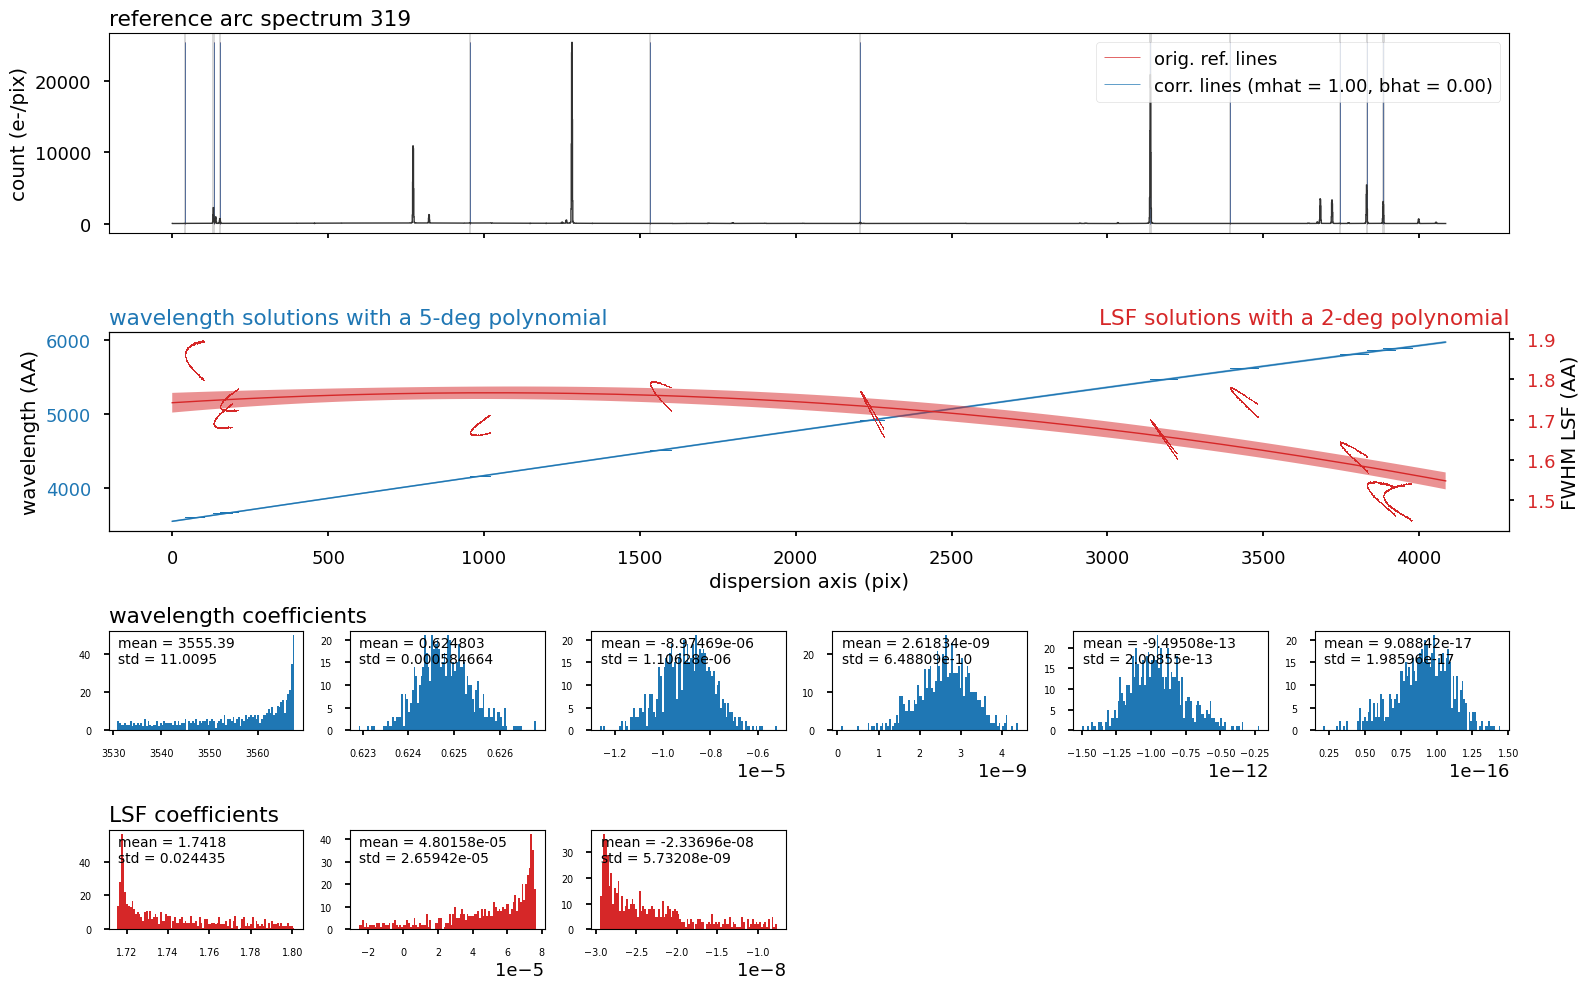

[INFO]: updating header and writing wavelength/LSF to '/home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mwave_neon_hgne_argon_xenon-b1.fits' and '/home/mejia/Research/lvm/lvmdata/calib/60177/lvm-mlsf_neon_hgne_argon_xenon-b1.fits'


In [21]:
ref_fibers = {"r2": 330, "r1": 319, "r3": 319, "z1": 319, "z2": 319, "z3": 319, "b3": 319, "b2": 319, "b1": 319}
lamp_combs = [tuple(lamp.lower() for lamp in ARC_LAMPS)]
arc_analogs = frames_table.query("imagetyp=='arc'").groupby(["camera"])

tileid = frames_table.tileid.iloc[0]

wmarc_paths = []
mwave_paths, mlsf_paths = [], []
for combs in lamp_combs:
    lamps_label = "_".join(combs)
    for camera in arc_analogs.groups:
        if camera != "b1": continue

        # define input/output paths
        warc_i_path = ",".join([path.full("lvm_master", drpver=drpver, tileid=tileid, mjd=masters_mjd, kind=f"wmarc_{lamp}", camera=camera) for lamp in combs])
        warc_path = path.full("lvm_master", drpver=drpver, tileid=tileid, mjd=masters_mjd, kind=f"wmarc_{lamps_label}", camera=camera)
        harc_path = path.full("lvm_master", drpver=drpver, tileid=tileid, mjd=masters_mjd, kind=f"hmarc_{lamps_label}", camera=camera)
        wmarc_paths.append(warc_path)
        
        # combine RSS files
        rssMethod.combineRSS_drp(in_rsss=warc_i_path, out_rss=warc_path, method="sum")
        
        # subtract continuum from each fiber
        # subtract_continuum(in_rss=warc_path, out_rss=warc_path, median_box=60, thresh=1.001, niter=1)
        
        # fix metadata and additional extensions
        rss_c = rssMethod.loadRSS(warc_path)
        rss_c.setSlitmap(Table(drp.fibermap.data))
        for lamp in combs:
            rss_c._header[lamp.upper()] = "ON"
        rss_c._header["OBJECT"] = ", ".join([lamp.capitalize() for lamp in combs])
        rss_c.writeFitsData(warc_path)
        print("combined lamps: ", warc_path)
        
        mwave_path = os.path.join(masters_path, f"lvm-mwave_{lamps_label}-{camera}.fits")
        mlsf_path = os.path.join(masters_path, f"lvm-mlsf_{lamps_label}-{camera}.fits")
        mwave_paths.append(mwave_path)
        mlsf_paths.append(mlsf_path)

        # determine wavelength solutions
        rssMethod.determine_wavelength_solution(in_arcs=warc_path, out_wave=mwave_path, out_lsf=mlsf_path, ref_fiber=ref_fibers.get(camera, 319), aperture=10, cc_correction=False,
                                                poly_disp=5, poly_fwhm=2, poly_cros=2, flux_min=1e-12, fwhm_max=5, rel_flux_limits=[0.001, 1e12], display_plots=True)

        # create pixel table
        rssMethod.create_pixel_table(in_rss=warc_path, out_rss=harc_path, arc_wave=mwave_path, arc_fwhm=mlsf_path)
        # resample
        iwave, fwave = SPEC_CHANNELS[camera[0]]
        rssMethod.resample_wavelength(in_rss=harc_path, out_rss=harc_path, method="linear", disp_pix=0.5, start_wave=iwave, end_wave=fwave, err_sim=10, parallel=0, extrapolate=False)

# new_masters = md.extract_metadata(frames_paths=wmarc_paths)
# md.add_masters(new_masters)